In [1]:
import pandas as pd
import os, re
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk import pos_tag
stemmer = PorterStemmer()
from string import punctuation
from random import seed
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
seed(1000)

In [2]:
 def removePuncs(text):
        puncs = [i for i in punctuation]
        for i in puncs:
            text = text.replace(i,"")
        return text


def preProcess(text):
    negtags = ["NN", "NNP", "NNPS", "POS", "PRP", "PRP$", "WP", "WP$", "IN", "EX", "CC", "DT", "PDT", "WDT","TO", "RP","FW", "MD", "SYM"]
    #remove punctuations
    text = removePuncs(text)

    #split text to words
    words = [word.strip().lower() for word in text.split()]
    #remove stopwords and numbers
    stops = stopwords.words("english")
    words = [word for word in words if word not in stops and word.isalpha()]
    #pos_tag words
    tagged = pos_tag(words)
    #remove unwanted tags
    tagged = [tag for tag in tagged if tag[1] not in negtags]
    words = [word[0] for word in tagged]
    #stem words
    words = [PorterStemmer().stem(word) for word in words]
    #join words to form sentence
    sentence = " ".join([word.strip() for word in words])
    return sentence


def termsPercentile(termsScores):
    percentiles = []
    for percentile in range(0,101,5):
        percentiles.append((percentile,np.percentile(termsScores, percentile)))
    final = pd.DataFrame(percentiles)
    final.columns = ["percentile", "score"]
    final['diffed'] = [0]+[round(final.score[i]-final.score[i-1],1) for i in range(1,len(percentiles))]
    return final
        
        

def CyberRelatedness(text, lexicon, scores):
    #lexicon is a dataframe of terms with their corresponding APMIS scores:columns labelled "terms", "apmis"
    #text is a single string input of text to be measured for degree of cyber-relatedness
    
    #get length of text
    text = text.strip().lower()
    sentLength = len(text.split())
    
    
    counter=[]
    
    for term in range(0,len(lexicon['terms'])):
        if lexicon['terms'][term] in text:
            counter.append(lexicon[scores][term])
            
            
    if len(counter) > 0:
        
        term_strength = sum(counter)/len(counter)
        sent_strength = len(counter)/sentLength
        
        return sent_strength/term_strength
    else:
        return 0  
    return counter

In [3]:
#read in test corpus files
basedir = "../DataCollection/corpus"
files = [basedir+"/"+i for i in os.listdir(basedir)]

In [4]:
data = []
for i in files:
    try:
        with open(i, "r+", encoding="utf-8") as ff:
            data.append(ff.readlines())
        ff.close()
    except:
        pass

In [5]:
data = [i for i in data if len(i)==5]

In [6]:
source = [i[0].strip() for i in data]
category = [i[1].strip() for i in data]
classed = [i[2].strip() for i in data]
text = [i[4].strip() for i in data]

In [7]:
data = pd.DataFrame([source,category,classed,text]).transpose()
data.columns = ["source","category","classed","text"]
data['text'] = [preProcess(i) for i in data.text]

In [8]:
data.head()

,source,category,classed,text
0,bbc,publishing,Cyber,butlin guest record expos hacker visitor butli...
1,bbc,publishing,Cyber,warn cyberattack nation say watersh hack
2,bbc,publishing,Cyber,nation say watersh hack ransomwar knock commun...
3,bbc,publishing,Cyber,record hijack research found motiontrigg clip ...
4,bbc,publishing,Cyber,daili mail googl chrome also flag argo roblox ...


In [9]:
data['classed'].value_counts()

Cyber       111
NonCyber    101
Name: classed, dtype: int64

In [10]:
data['source'].unique()

array(['bbc', 'facebook', 'hackernews', 'linkedin', 'quora', 'reddit',
       'stackx', 'steemit'], dtype=object)

In [11]:
pd.crosstab(data.source, data.classed)

classed,Cyber,NonCyber
source,,
bbc,15,15
facebook,15,13
hackernews,14,0
linkedin,9,14
quora,15,15
reddit,15,15
stackx,14,14
steemit,14,15


In [12]:
#read in scores
apmis =  pd.read_csv("../../BuildingCyberLexicon/Analysis/absapmis.csv")
tfidf = pd.read_csv("../../BuildingCyberLexicon/Analysis/tfidf_scores.csv")
fdr = pd.read_csv("../../BuildingCyberLexicon/Analysis/frequency_degree_ratio.csv")

## TERMS SELECTION

In [13]:
apmis.head()

,Unnamed: 0,terms,apmis
0,user,user,5.220217
1,actual,actual,5.111989
2,window,window,5.026499
3,write,write,3.913943
4,updat,updat,3.810726


In [14]:
aptp = termsPercentile(apmis.apmis)
aptp.to_csv("apmisPercentile.csv")
aptp

,percentile,score,diffed
0,0,-1.289451,0.0
1,5,-1.162939,0.1
2,10,-1.051182,0.1
3,15,-0.936679,0.1
4,20,-0.835521,0.1
5,25,-0.734556,0.1
6,30,-0.647370,0.1
7,35,-0.542739,0.1
8,40,-0.443825,0.1
9,45,-0.312003,0.1


In [15]:
tfidf.head()

,Unnamed: 0,tdif,terms
0,http,9.750110,http
1,enter,8.599452,enter
2,run,6.099571,run
3,data,5.828301,data
4,free,5.792339,free


In [16]:
tftp= termsPercentile(tfidf.tdif)
tftp.to_csv("tfidfPercentile.csv")
tftp

,percentile,score,diffed
0,0,-0.756527,0.0
1,5,-0.726090,0.0
2,10,-0.697132,0.0
3,15,-0.666464,0.0
4,20,-0.637894,0.0
5,25,-0.608110,0.0
6,30,-0.565212,0.0
7,35,-0.519438,0.0
8,40,-0.463074,0.1
9,45,-0.414721,0.0


In [17]:
fdr.head()

,Unnamed: 0,degree,frequency,ratio,terms
0,administr,5063,625,3.553672,administr
1,agenc,5105,654,3.367843,agenc
2,action,6159,876,2.879637,action
3,analyz,4325,632,2.761541,analyz
4,amount,3599,539,2.656859,amount


In [18]:
fdrtp= termsPercentile(fdr.ratio)
fdrtp.to_csv("fdrPercentile.csv")
fdrtp

,percentile,score,diffed
0,0,-1.549444,0.0
1,5,-1.400336,0.1
2,10,-1.288871,0.1
3,15,-1.141991,0.1
4,20,-1.010212,0.1
5,25,-0.862172,0.1
6,30,-0.692227,0.2
7,35,-0.528262,0.2
8,40,-0.384269,0.1
9,45,-0.224873,0.2


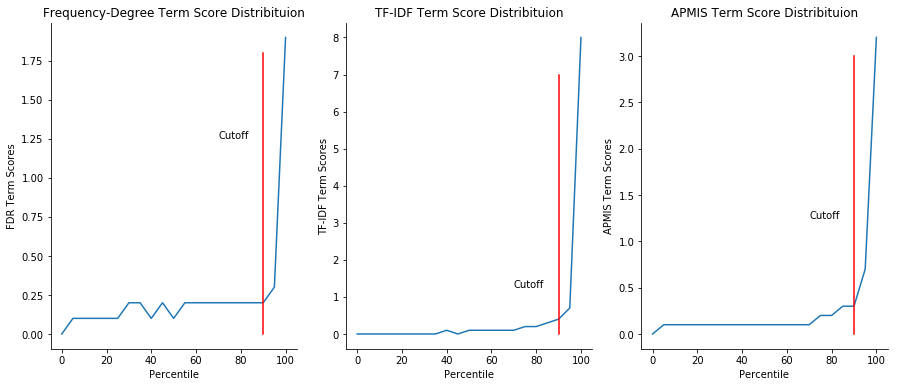

In [19]:
f, axes = plt.subplots(1,3,figsize=(15,6))

ax1 = sns.lineplot(fdrtp.percentile,fdrtp.diffed, ax=axes[0])
ax1.set_title("Frequency-Degree Term Score Distribituion")
ax1.set_ylabel("FDR Term Scores")
ax1.set_xlabel("Percentile")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.plot([90,90],[0,1.8], color='red')
ax1.text(70,1.25,"Cutoff")


ax2 = sns.lineplot(tftp.percentile,tftp.diffed, ax=axes[1])
ax2.set_title("TF-IDF Term Score Distribituion")
ax2.set_ylabel("TF-IDF Term Scores")
ax2.set_xlabel("Percentile")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.plot([90,90],[0,7], color='red')
ax2.text(70,1.25,"Cutoff")


ax3= sns.lineplot(aptp.percentile,aptp.diffed, ax=axes[2])
ax3.set_title("APMIS Term Score Distribituion")
ax3.set_ylabel("APMIS Term Scores")
ax3.set_xlabel("Percentile")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.plot([90,90],[0,3], color='red')
ax3.text(70,1.25,"Cutoff")

plt.savefig('percentileCutoff.png')

In [20]:
top_apmis = apmis.loc[apmis['apmis'] >= 1.321439]
top_tfidf = tfidf.loc[tfidf['tdif'] > 1.090684]
top_fdr = fdr.loc[fdr['ratio'] > 1.698976]

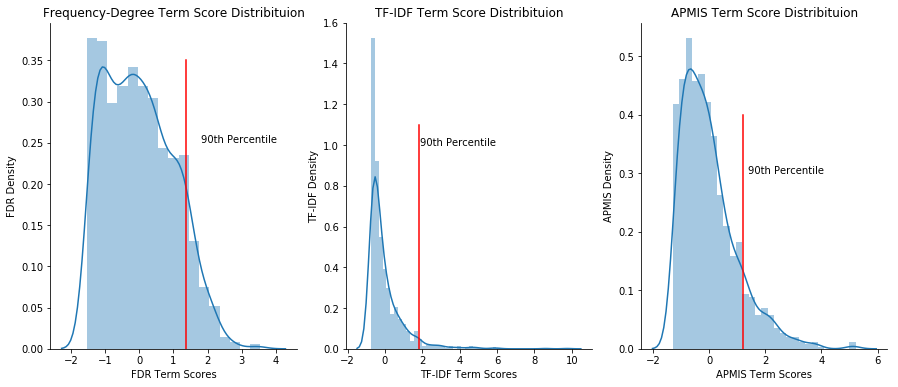

In [21]:
f, axes = plt.subplots(1,3,figsize=(15,6))

ax1 = sns.distplot(fdr.ratio,kde=True, ax=axes[0])
ax1.set_title("Frequency-Degree Term Score Distribituion")
ax1.set_ylabel("FDR Density")
ax1.set_xlabel("FDR Term Scores")
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.plot([1.38,1.38],[0,0.35], color='red')
ax1.text(1.8,0.25,"90th Percentile")



ax2=sns.distplot(tfidf.tdif,kde=True, ax=axes[1])
ax2.set_title("TF-IDF Term Score Distribituion")
ax2.set_ylabel("TF-IDF Density")
ax2.set_xlabel("TF-IDF Term Scores")
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.plot([1.8,1.8],[0,1.1], color='red')
ax2.text(1.9,1.0,"90th Percentile")



ax3=sns.distplot(apmis.apmis,kde=True, ax=axes[2])
ax3.set_title("APMIS Term Score Distribituion")
ax3.set_ylabel("APMIS Density")
ax3.set_xlabel("APMIS Term Scores")
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.plot([1.2,1.2],[0,0.4], color='red')
ax3.text(1.4,0.3,"90th Percentile")

plt.savefig('termScoresDistribution.png')

## Performance Evaluation

In [33]:
from sklearn.metrics import confusion_matrix as cm
def evaluate(ev_data, terms_data, scores, applied, label):
    
    cutoffs = []
    percentiles = []
    accuracies = []
    errors=[]
    precisions=[]
    recalls=[]
    fprs=[]
    f1s=[]
    tabs=[]
    
    for percentile in range(0,100):
        #med = np.percentile(applied,percentile)
        ev_data[label]=["Cyber" if i>percentile else "NonCyber" for i in applied]
        tab = pd.crosstab(ev_data['classed'], ev_data[label])
        tabs.append(tab)
    
        
        #tn,fp,fn,tp = tab.ravel()
        try:
            tp = tab.iloc[0,0]
        except:
            tp = 0
        
        try:
            fn = tab.iloc[0,1]
        except:
            fn = 0
        
        try:
            fp = tab.iloc[1,0]
        except:
            fp=0
        
        try:
            tn = tab.iloc[1,1]
        except:
            tn=0
            
        total=fp+fn+tp+tn
        
        cutoff = round(percentile, 2)
        cutoffs.append(cutoff)
        
        error=(fp+fn)/total
        errors.append(error)
        
        accuracy=(tp+tn)/total
        accuracies.append(accuracy)
        
        precision=(tp)/(tp+fp)
        precisions.append(precision)
        
        recall = tp/(tp+fn)
        recalls.append(recall)
        
        fpr = 1-(tn)/(tn+fp)
        fprs.append(fpr)
        
        f1 = 2*(recall * precision) / (recall + precision)
        f1s.append(f1)
        
        
    data = pd.DataFrame([[i for i in range(0,100)],cutoffs,accuracies,errors,precisions,recalls,fprs,f1s]).transpose()
    data.columns = ['Percentile','Cutoff', 'Accuracy', 'ErrorRate','Precision','Recall', 'FPR', 'f1Score']

    return (data, tabs)

In [34]:
ev_apmis = [CyberRelatedness(txt, top_apmis, "apmis") for txt in data['text']]
ev_apmis = np.interp(ev_apmis, (min(ev_apmis), max(ev_apmis)), (0,100))


ev_tf = [CyberRelatedness(txt, top_tfidf, "tdif") for txt in data['text']]
ev_tf = np.interp(ev_tf, (min(ev_tf), max(ev_tf)), (0,100))


ev_fdr = [CyberRelatedness(txt, top_fdr, "ratio") for txt in data['text']]
ev_fdr = np.interp(ev_fdr, (min(ev_fdr), max(ev_fdr)), (0,100))


In [35]:
top_apmis['terms'] = [stemmer.stem(i).strip().lower() for i in top_apmis.terms]
top_apmis['scaled'] = np.interp(top_apmis.apmis, (top_apmis.apmis.min(), top_apmis.apmis.max()), (0,100))
apee=evaluate(data,top_apmis,"scaled",ev_apmis, "apmisLabels")


top_tfidf['terms'] = [stemmer.stem(i).strip().lower() for i in top_tfidf.terms]
top_tfidf['scaled'] = np.interp(top_tfidf.tdif, (top_tfidf.tdif.min(), top_tfidf.tdif.max()), (0,100))
tfee=evaluate(data,top_tfidf,"tdif",ev_tf, "tfidfLabels")


top_fdr['terms'] = [stemmer.stem(i).strip().lower() for i in top_fdr.terms]
top_fdr['scaled'] = np.interp(top_fdr.ratio, (top_fdr.ratio.min(), top_fdr.ratio.max()), (0,100))
fdee=evaluate(data,top_fdr,"ratio",ev_fdr, "fdrLabels")


In [36]:
apee[0]

,Percentile,Cutoff,Accuracy,ErrorRate,Precision,Recall,FPR,f1Score
0,0.0,0.0,0.589623,0.410377,0.580000,0.783784,0.623762,0.666667
1,1.0,1.0,0.589623,0.410377,0.580000,0.783784,0.623762,0.666667
2,2.0,2.0,0.589623,0.410377,0.580000,0.783784,0.623762,0.666667
3,3.0,3.0,0.589623,0.410377,0.580000,0.783784,0.623762,0.666667
4,4.0,4.0,0.589623,0.410377,0.580000,0.783784,0.623762,0.666667
5,5.0,5.0,0.584906,0.415094,0.577181,0.774775,0.623762,0.661538
6,6.0,6.0,0.584906,0.415094,0.577181,0.774775,0.623762,0.661538
7,7.0,7.0,0.575472,0.424528,0.571429,0.756757,0.623762,0.651163
8,8.0,8.0,0.584906,0.415094,0.579310,0.756757,0.603960,0.656250
9,9.0,9.0,0.589623,0.410377,0.583333,0.756757,0.594059,0.658824


In [37]:
apee[1][5]

apmisLabels,Cyber,NonCyber
classed,,
Cyber,86,25
NonCyber,63,38


In [46]:
terms = list(top_apmis['terms'])+list(top_fdr['terms'])+list(top_tfidf['terms'])
terms = list(set(terms))

In [47]:
len(terms)

217

In [38]:
apee[0].to_csv("apee.csv")

In [39]:
tfee[0]

,Percentile,Cutoff,Accuracy,ErrorRate,Precision,Recall,FPR,f1Score
0,0.0,0.0,0.580189,0.419811,0.563953,0.873874,0.742574,0.685512
1,1.0,1.0,0.580189,0.419811,0.563953,0.873874,0.742574,0.685512
2,2.0,2.0,0.589623,0.410377,0.570588,0.873874,0.722772,0.690391
3,3.0,3.0,0.589623,0.410377,0.570588,0.873874,0.722772,0.690391
4,4.0,4.0,0.599057,0.400943,0.578313,0.864865,0.693069,0.693141
5,5.0,5.0,0.608491,0.391509,0.586420,0.855856,0.663366,0.695971
6,6.0,6.0,0.608491,0.391509,0.586420,0.855856,0.663366,0.695971
7,7.0,7.0,0.608491,0.391509,0.588608,0.837838,0.643564,0.691450
8,8.0,8.0,0.617925,0.382075,0.596154,0.837838,0.623762,0.696629
9,9.0,9.0,0.613208,0.386792,0.597315,0.801802,0.594059,0.684615


In [43]:
tfee[1][13]

tfidfLabels,Cyber,NonCyber
classed,,
Cyber,79,32
NonCyber,48,53


In [44]:
fdee[0]

,Percentile,Cutoff,Accuracy,ErrorRate,Precision,Recall,FPR,f1Score
0,0.0,0.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
1,1.0,1.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
2,2.0,2.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
3,3.0,3.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
4,4.0,4.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
5,5.0,5.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
6,6.0,6.0,0.622642,0.377358,0.731343,0.441441,0.178218,0.550562
7,7.0,7.0,0.617925,0.382075,0.727273,0.432432,0.178218,0.542373
8,8.0,8.0,0.627358,0.372642,0.750000,0.432432,0.158416,0.548571
9,9.0,9.0,0.627358,0.372642,0.758065,0.423423,0.148515,0.543353


In [45]:
fdee[1][21]

fdrLabels,Cyber,NonCyber
classed,,
Cyber,31,80
NonCyber,5,96


In [42]:
min(tfee[0].ErrorRate)

0.37735849056603776

In [28]:
metrics = ["Precision", "Recall", "ErrorRate", "f1Score"]

NameError: name 'j' is not defined

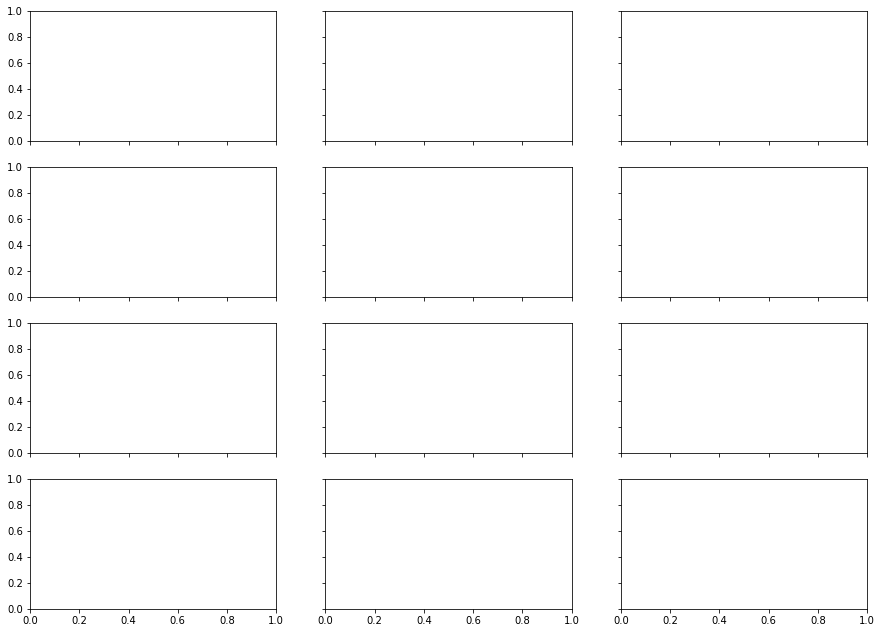

In [29]:
f, axes = plt.subplots(4,3,figsize=(15,11), sharex=True, sharey=True)


ax1 = sns.scatterplot(apee.Cutoff,apee[j], ax=axes[0,0])
ax2 = sns.scatterplot(tfee.Cutoff,tfee[j], ax=axes[0,1])
ax3 = sns.scatterplot(tfee.Cutoff,fdee[j], ax=axes[0,2])



ax4 = sns.scatterplot(apee.Cutoff,apee.Precision, ax=axes[1,0])
ax5 = sns.scatterplot(tfee.Cutoff,tfee.Precision, ax=axes[1,1])
ax6 = sns.scatterplot(fdee.Cutoff,fdee.Precision, ax=axes[1,2])


ax7 = sns.scatterplot(apee.Cutoff,apee.ErrorRate, ax=axes[2,0])
ax8 = sns.scatterplot(tfee.Cutoff,tfee.ErrorRate, ax=axes[2,1])
ax9 = sns.scatterplot(fdee.Cutoff,fdee.ErrorRate, ax=axes[2,2])

ax10 = sns.scatterplot(apee.Cutoff,apee.f1Score, ax=axes[3,0])
ax11 = sns.scatterplot(tfee.Cutoff,tfee.f1Score, ax=axes[3,1])
ax12 = sns.scatterplot(fdee.Cutoff,fdee.f1Score, ax=axes[3,2])
